## 앙상블: '집단 지성'으로 예측 정확도를 극대화

  - **핵심 원리**: 하나의 모델 대신, 여러 개의 모델을 조화롭게 학습시켜 그 예측 결과들을 함께 이용하면 더 정확한 예측값을 구할 수 있음.
  - **`앙상블(Ensemble)`**: 여러 분류기를 결합하여 개별 분류기보다 더 나은 일반화 성능을 갖게 하는 기법. 여러 '약한 분류기(Weak Classifier)'를 결합하여 '강한 분류기(Strong Classifier)'를 만드는 것이 핵심.
  - **실무 적용**: `부정탐지시스템(FDS)`과 같이 성능과 속도가 중요한 경우, \*\*`XGBoost`\*\*나 **`LGBM`** 같은 부스팅 계열 모델을 우선 검토. \*\*`RandomForest`\*\*나 **`딥러닝`** 모델도 비교 대상이 될 수 있음.
  - **학습 목표**: \*\*`배깅(Bagging)`\*\*과 \*\*`부스팅(Boosting)`\*\*의 원리를 이해하고, 여러 단일 모델의 성능을 비교한 뒤, 이들을 결합하여 성능을 극대화하는 **`투표(Voting)`** 기반 앙상블 기법을 학습.

-----

## 핵심 원리 파헤치기 (Deep Dive)

  - 앙상블 모형은 크게 `배깅(Bagging)`과 `부스팅(Boosting)`으로 나뉘며, 이들의 기반에는 `부트스트래핑` 기법이 있음.

### 1\. 앙상블의 기초 체력: `부트스트래핑`과 `0.632 규칙`

  - **`부트스트래핑(bootstrapping)`**: n개의 관찰로 구성된 원본 데이터셋에서 **중복을 허용하여(복원추출)** 무작위로 샘플링하는 과정.
  - **`0.632 규칙`**: 부트스트래핑을 수행하면 원본 데이터의 약 \*\*63.2%\*\*만이 샘플링된 데이터셋에 포함됨.
  $$lim_{n\rightarrow\infty}(1-\frac{1}{n})^{n}=e^{-1}\approx0.368$$
  - **`OOB(Out-of-Bag)` 데이터**: 샘플링되지 않은 나머지 약 36.8%의 데이터. 모델을 검증하는 데 매우 유용하게 사용됨.

### 2\. 앙상블의 두 기둥: `배깅` vs `부스팅`

  - **`배깅(Bagging)`**: 'Bootstrap Aggregating'의 약자.
      - **과정**: 부트스트래핑으로 여러 훈련 데이터셋을 만들고, 각 데이터셋으로 별개의 모델을 **병렬적**으로 학습시킨 후, 결과를 종합(주로 투표)하여 최종 결정을 내림.
      - **목표**: **분산을 줄여** 과적합을 방지하는 데 효과적.
  - **`부스팅(Boosting)`**:
      - **과정**: 여러 모델을 **순차적**으로 학습. 이전 모델이 틀린 데이터에 가중치를 부여하여, 다음 모델이 이전 모델의 실수를 보완하도록 학습.
      - **목표**: 잘못 분류된 데이터에 집중하여 **편향을 줄이는** 데 효과적.

### 3\. 최종 결정 방식: `Hard Voting` vs `Soft Voting`

  - 여러 모델의 예측을 하나로 합치는 대표적인 방법은 '투표'.
  - **`Hard Voting` (하드 보팅)**: 단순 다수결 방식. 각 모델이 예측한 클래스 레이블 중 가장 많은 표를 얻은 클래스를 최종 결론으로 채택.
  - **`Soft Voting` (소프트 보팅)**: 확률 기반 가중 투표 방식. 각 모델이 예측한 클래스별 '확률' 값의 평균이 가장 높은 클래스를 최종 결론으로 채택. 일반적으로 더 좋은 성능을 보임.

-----

## 실전 코드 분석 및 적용 (Code Walkthrough & Application)

### Section 1: 배깅(Bagging) 기법 실습 - 와인 데이터 분류

#### 1-1. 데이터 로딩 및 전처리

  - UCI 머신러닝 저장소의 와인 데이터셋을 사용.

<!-- end list -->

In [5]:
# '복사-붙여넣기'만으로 즉시 실행 가능하도록 라이브러리를 import합니다.
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# UCI 저장소에서 와인 데이터셋 불러오기
wine_df = pd.read_csv("https://archive.ics.uci.edu"
                      "/ml/machine-learning-databases/wine/wine.data",
                      header=None)

# 변수명(컬럼명) 설정
wine_df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

- 이진 분류 예제를 위해 1등급 와인을 제외하고, `Alcohol`와 `Hue` 두 변수만 사용.

<!-- end list -->

In [6]:
# 1등급 와인 데이터 제외
wine_df = wine_df[wine_df['Class label'] != 1]

# 독립변수(X)와 종속변수(y) 설정
X = wine_df[["Alcohol", "Hue"]].values
y = wine_df["Class label"].values

# 레이블 인코딩 (클래스 2, 3을 0, 1로 변환)
le = LabelEncoder()
y = le.fit_transform(y)

# 훈련 데이터와 테스트 데이터 분리 (6:4 비율)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4,
                                                    random_state=1,
                                                    stratify=y) # stratify=y 추가로 클래스 비율 유지

#### 1-2. Baseline: 단일 의사결정나무 모델

  - 앙상블을 사용하지 않은 일반 의사결정나무 모델의 성능을 기준점으로 측정.

<!-- end list -->

In [7]:
# 의사결정나무 모델 생성 및 학습
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
tree.fit(train_X, train_y)

# 모델 성능(정확도) 평가
print(f"결정 트리 정확도: {tree.score(test_X, test_y):.4f}")

결정 트리 정확도: 0.8750


- **코드 해설**: 단일 의사결정나무 모델의 분류 정확도는 약 85.4%로 나타났음.

#### 1-3. `BaggingClassifier`를 이용한 앙상블

  - 동일한 의사결정나무를 기본 추정기로 사용하여 500개의 모델로 구성된 배깅 앙상블 모델 생성.

<!-- end list -->

In [8]:
# 배깅 분류기 모델 생성 및 학습
bag = BaggingClassifier(estimator=tree, n_estimators=500,
                        bootstrap=True, bootstrap_features=False,
                        random_state=1)
bag.fit(train_X, train_y)

# 배깅 모델 성능(정확도) 평가
print(f"배깅 정확도: {bag.score(test_X, test_y):.4f}")

배깅 정확도: 0.8958


- **코드 해설**: `BaggingClassifier`를 사용한 앙상블 모델의 정확도는 약 89.6%로, 단일 의사결정나무보다 성능이 향상되었음.

#### 1-4. `RandomForestClassifier`를 이용한 앙상블

  - **`랜덤 포레스트(RandomForest)`**: 배깅에 추가적인 무작위성을 더한 기법. 데이터뿐만 아니라, 의사결정나무의 각 노드를 분할할 때 사용하는 변수(feature)도 무작위로 샘플링.

<!-- end list -->

In [9]:
# 랜덤 포레스트 모델 생성 및 학습
rf = RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

# 랜덤 포레스트 모델 성능(정확도) 평가
print(f"랜덤 포레스트 정확도: {rf.score(test_X, test_y):.4f}")

랜덤 포레스트 정확도: 0.9375


- **코드 해설**: `RandomForestClassifier` 모델의 정확도는 약 89.6%로, 배깅과 유사한 높은 성능을 보였음. 변수까지 무작위로 선택하는 과정이 모델의 일반화 성능을 높인 것임.

#### 1-5. 결정 경계 시각화 비교

  - 세 가지 모델의 결정 경계를 시각화하여 비교.

<!-- end list -->

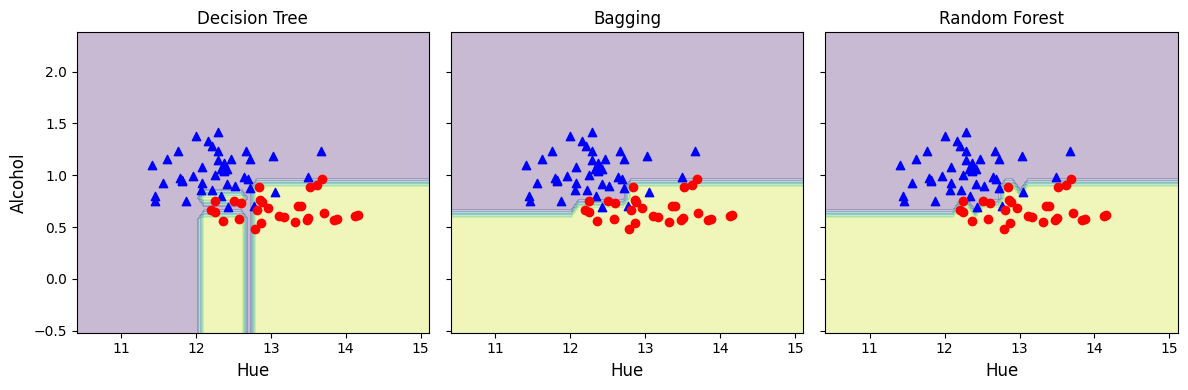

In [10]:
# 시각화를 위한 그리드 생성
x_min, x_max = train_X[:, 0].min() - 1, train_X[:, 0].max() + 1
y_min, y_max = train_X[:, 1].min() - 1, train_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# 3개의 subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row', figsize=(12, 4))

# 모델 정보
model_info = zip([0, 1, 2], [tree, bag, rf], ['Decision Tree', 'Bagging', 'Random Forest'])

for idx, model, title_txt in model_info:
    model.fit(train_X, train_y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axes[idx].contourf(xx, yy, Z, alpha=0.3)
    axes[idx].scatter(train_X[train_y == 0, 0], train_X[train_y == 0, 1], c='blue', marker='^')
    axes[idx].scatter(train_X[train_y == 1, 0], train_X[train_y == 1, 1], c='red', marker='o')
    axes[idx].set_title(title_txt)
    axes[idx].set_xlabel('Hue', fontsize=12)

axes[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.show()

- **코드 해설**: 시각화 결과, 단일 의사결정나무는 경계가 복잡하여 과적합 경향을 보임. 반면, \*\*`배깅`\*\*과 \*\*`랜덤 포레스트`\*\*는 여러 나무의 예측을 평균내는 효과 덕분에 결정 경계가 훨씬 부드럽고 일반화되었음을 확인할 수 있음.

### Section 2: 부스팅(Boosting) 기법 실습 - 와인 데이터 분류

  - **`부스팅`**: 모델을 순차적으로 학습하며, 이전 모델이 틀린 데이터에 가중치를 부여해 다음 모델이 어려운 문제에 더 집중하도록 만드는 방식.

#### 2-1. `AdaBoostClassifier`

In [11]:
from sklearn.ensemble import AdaBoostClassifier

abm = AdaBoostClassifier(base_estimator=tree, n_estimators=500, random_state=1)
abm.fit(train_X, train_y)
print(f"AdaBoost 정확도: {abm.score(test_X, test_y):.4f}")

TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'base_estimator'

#### 2-2. `GradientBoostingClassifier`

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(n_estimators=500, random_state=1)
gbm.fit(train_X, train_y)
print(f"Gradient Boosting 정확도: {gbm.score(test_X, test_y):.4f}")

#### 2-3. `XGBoost`

  - GBM보다 빠르며, 과적합 방지를 위한 `규제` 및 `조기 종료` 기능이 포함된 알고리즘.

<!-- end list -->

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=500, random_state=1, use_label_encoder=False, eval_metric='logloss')
xgb.fit(train_X, train_y)
print(f"XGBoost 정확도: {xgb.score(test_X, test_y):.4f}")

#### 2-4. `LightGBM`

  - XGBoost와 달리 `리프 중심 트리 분할(Leaf Wise)` 방식을 사용하여 예측 오류 손실을 최소화.

<!-- end list -->

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=500, random_state=1)
lgbm.fit(train_X, train_y)
print(f"LightGBM 정확도: {lgbm.score(test_X, test_y):.4f}")

### Section 3: 최적 파라미터 탐색 (`GridSearchCV`)

  - `GridSearchCV`를 이용해 `XGBoost` 모델의 `max_depth`와 `subsample` 파라미터 최적값을 탐색.

<!-- end list -->

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {'max_depth': [3, 5, 7, 9],
                  'subsample': [0.4, 0.6, 0.8, 1.0]}

grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid,
                      scoring='roc_auc', n_jobs=-1, cv=5,
                      refit=True, return_train_score=True)
grid.fit(train_X, train_y)

- **코드 해설**: `GridSearchCV`를 통해 16개 조합을 테스트한 결과, **`subsample`이 0.6일 때** `max_depth`에 상관없이 가장 좋은 성능을 보인다는 것을 알 수 있음.

### Section 4: 종합 실습 - `VotingClassifier`로 최적의 조합 찾기

#### 4-1. 데이터 준비 (불균형 데이터 생성 및 오버샘플링)

In [ ]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

X, y = make_classification(n_samples=1000, n_features=10, n_informative=5,
                           n_redundant=0, n_clusters_per_class=1,
                           n_classes=2, weights=[0.99, 0.01],
                           random_state=42)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=42)
sm = SMOTE(random_state=42)
resampled_X, resampled_y = sm.fit_resample(train_X, train_y)

#### 4-2. 개별 모델 성능 비교

  - 모델 평가 자동화 함수 정의.

<!-- end list -->

In [ ]:
def model_measure(model, train_X, train_y, test_X, test_y):
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    cm = confusion_matrix(test_y, y_pred)
    precision = cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0
    f1score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"precision: {precision:.6f}, recall: {recall:.6f}, f1score: {f1score:.6f}")

- `RandomForest`, `SVM`, `MLP`, `XGBoost`, `LightGBM` 모델의 성능을 각각 측정.

#### 4-3. `VotingClassifier`를 이용한 앙상블

  - RandomForest, XGBoost, LightGBM 세 가지 모델을 `hard` 보팅 방식으로 묶어 앙상블 모델 생성 및 평가.

<!-- end list -->

In [ ]:
from sklearn.ensemble import VotingClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_features=2, random_state=42)
xgb_model = XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.01, use_label_encoder=False, eval_metric='logloss')
lgb_model = LGBMClassifier(n_estimators=100, random_state=42)

voting_model = VotingClassifier(estimators=[("rfc", rf_model),
                                          ("xgb", xgb_model),
                                          ("lgbm", lgb_model)],
                              voting="hard")

print("Voting Classifier (hard):")
model_measure(voting_model, resampled_X, resampled_y, test_X, test_y)

- **코드 해설**: **`VotingClassifier`** 앙상블 모델의 f1-score는 0.5789로, 단일 모델 중 가장 성능이 좋았던 LightGBM(0.5641)보다 향상된 결과를 보였음. 이는 서로 다른 강점을 가진 모델들을 결합하여 더 안정적이고 정확한 예측을 만들어낸 앙상블의 힘을 보여줌.

-----

## 핵심 요약 (Key Takeaways)

  - **앙상블의 시작은 부트스트래핑**: \*\*`부트스트래핑`\*\*은 배깅과 랜덤 포레스트의 기본 원리이며, 샘플링되지 않은 **OOB(Out-of-Bag)** 데이터는 모델 검증에 유용하게 사용될 수 있음.
  - **배깅 vs 부스팅**: \*\*`배깅`\*\*은 독립적인 모델들을 병렬로 학습시켜 과적합을 줄이는 데 효과적이며, \*\*`부스팅`\*\*은 이전 모델의 실수를 보완하며 순차적으로 학습시켜 편향을 줄이는 데 강점이 있음.
  - **최적의 조합을 찾는 노력**: \*\*`GridSearchCV`\*\*를 사용한 하이퍼파라미터 튜닝은 모델 성능을 끌어올리는 필수 과정임. 또한, \*\*`VotingClassifier`\*\*를 이용해 잘 튜닝된 여러 모델을 결합하면 단일 모델의 한계를 뛰어넘는 더 강력한 최종 모델을 만들 수 있음.